# 04 - Modelling

__Goal__: 
- Test some linear models (logistic regression, linear SVM) and nonlinear models (SVM with RBF kernel, decision tree, random forest)
- We select the best model on "validation" metrics, and provide its score on "test" metrics.
- 1 means "rain", 0 means "no rain".
- Working when raining is prejudical. We want to predict as much true "rain" as possible.
- High recall means you less often ask the docker to work during a rainy day.  This causes higher management costs.
- High precision means you don't ask the docker to stay at home while the weather is good. This causes higher delays in delivery.
- The f1-score is a trade-off between precision  and recall.
- The `normalize` parameter `{"true", "pred", "all"}` in `confusin_matrix_evaluation()` normalizes confusion matrix over the true (rows), predicted (columns) conditions or all the population. If `None`, confusion matrix will not be normalized.

1. Logistic regression
2. Linear SVC
3. SVC with RBF kernel
4. Decision Tree
5. Random Forest
6. Test metrics consistancy with pikled pipelines and  models

### Import

In [1]:
%load_ext autoreload
%autoreload 2
import joblib
import pandas as pd
from pathlib import Path

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    ConfusionMatrixDisplay,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier

from weather.transformers.transformer_makers import (
    FeatureNames,
    TargetChoice,
    make_dataset_transformer,
    make_remove_horizonless_rows_transformer,
    make_target_creation_transformer,
    make_predictors_feature_engineering_transformer,
)
from weather.data.prep_datasets import (
    prepare_binary_classification_tabular_data, 
    transform_dataset_and_create_target,
    remove_horizonless_rows,
)
from weather.helpers.utils import camel_to_snake
from weather.models.skl_train_models import (
    score_evaluation,
    print_accuracy_results,
    confusion_matrix_evaluation,
    confusion_matrix_display,
)

In [2]:
data_dir =  Path.cwd().parent / "data"
models_dir = Path.cwd().parent / "models"
models_dir.mkdir(exist_ok=True)

# 1. Prepare the `dataset` for modelization

### Select the predictors and set the target

In [3]:
# Select the predictors
feature_names = FeatureNames(
    numerical=[
        "Temperature",
        "Humidity",
        "Wind_speed",
        "Wind_bearing",
        "Visibility",
        "Pressure",
    ],
    categorical=[],  # Add or remove "Weather", "Month" to the predictors
)

# Set "Weather" within 4 hours as target
target_name = "Weather"
horizon = 4
target_choice = TargetChoice(target_name, horizon) 

### Set the dataset transformers

In [4]:
oldnames_newnames_dict = {
    "Temperature_C": "Temperature", 
    "Apparent_Temperature_C": "Apparent_temperature",
    "Wind_speed_kmph": "Wind_speed",
    "Wind_bearing_degrees": "Wind_bearing",
    "Visibility_km": "Visibility",
    "Pressure_millibars": "Pressure",
    "Weather_conditions": "Weather"}

dataset_transformer = make_dataset_transformer(target_choice, oldnames_newnames_dict)                  
target_creation_transformer = make_target_creation_transformer(target_choice)                       
predictors_feature_engineering_transformer = make_predictors_feature_engineering_transformer(feature_names, target_choice)
remove_horizonless_rows_transformer = make_remove_horizonless_rows_transformer(target_choice)   

### Read the data

In [5]:
df = pd.read_csv(data_dir / 'weather_dataset_raw_development.csv')
df.head(1)

,S_No,Timestamp,Location,Temperature_C,Apparent_Temperature_C,Humidity,Wind_speed_kmph,Wind_bearing_degrees,Visibility_km,Pressure_millibars,Weather_conditions
0,2881,2006-01-01 00:00:00+00:00,"Port of Turku, Finland",1.161111,-3.238889,0.85,16.6152,139,9.9015,1016.15,rain


### Transform the dataset

In [6]:
# Three transformers are used: "dataset_transformer", "target_creation_transformer", "remove_horizonless_rows_transformer"
transformed_data, created_target = transform_dataset_and_create_target(
    df,   
    dataset_transformer,
    target_creation_transformer,
)

dataset = prepare_binary_classification_tabular_data(
    transformed_data,
    created_target,
)

dataset = remove_horizonless_rows(
    dataset,
    remove_horizonless_rows_transformer,
)

# 2. Model the dataset

### Define models

In [7]:
models = {
    "DecisionTree": {
        "model": DecisionTreeClassifier(max_depth=4),
    },
    "LinearSvc": {
        "model": LinearSVC(max_iter=10_000, random_state=0),
    },
    "LogisticRegression": {
        "model": LogisticRegression(),
    },
    "RandomForest": {
        "model": RandomForestClassifier(max_depth=4),
        #"param_grid": {"model__n_estimators": [5, 10], "model__max_depth": [None, 5, 10]},
    },
    "SvcWithRbfKernel": {
        "model": SVC(kernel="rbf", gamma=0.7, random_state=0),
    },
}

### Metrics parameters

In [8]:
normalize = "all"  # for confusion matrices

### Transformer

A fourth transformer is used for training: `predictors_feature_engineering_transformer`.

###  1 -  `LogisticRegression`

Score(score_name='accuracy_score', train=0.895, valid=0.883, test=0.86)
Score(score_name='precision_score', train=0.899, valid=0.882, test=0.856)
Score(score_name='recall_score', train=0.986, valid=0.999, test=0.997)
Score(score_name='f1_score', train=0.94, valid=0.937, test=0.921)


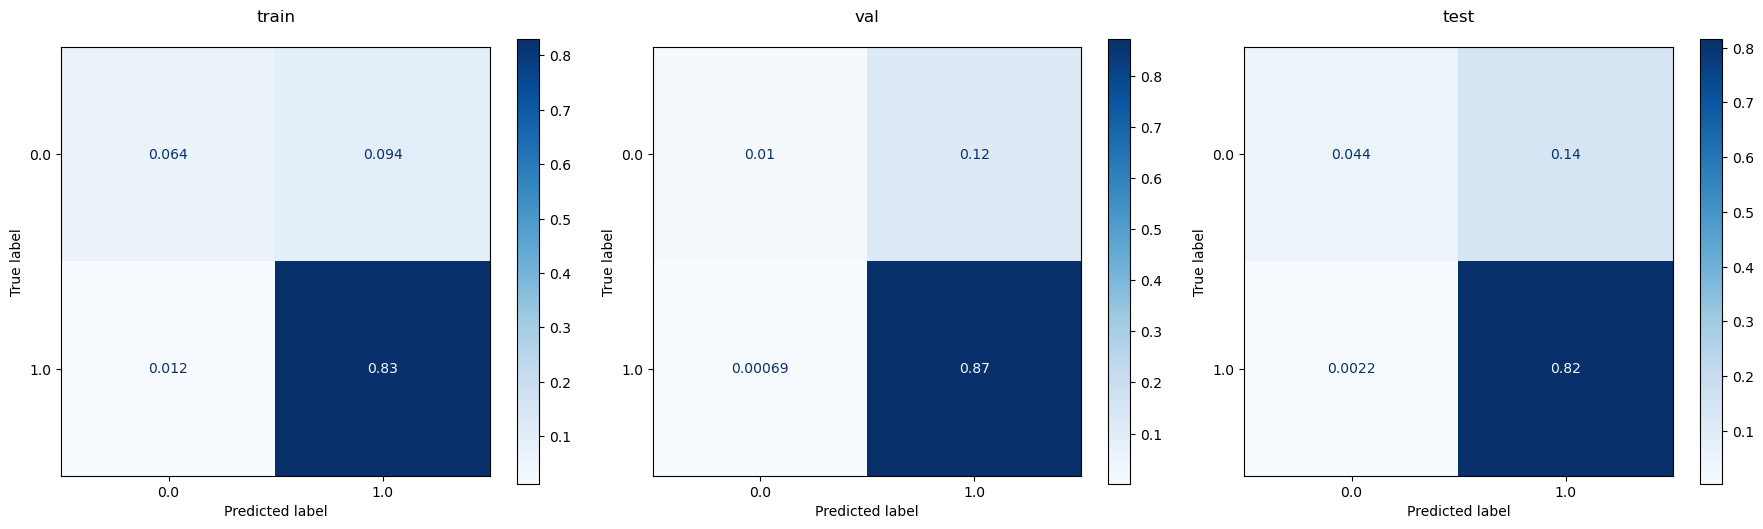

In [9]:
model_name = "LogisticRegression"
model = models[model_name]["model"]

# Train
predictors_feature_engineering_transformer.fit(dataset.train_x)
model.fit(predictors_feature_engineering_transformer.transform(dataset.train_x), dataset.train_y)

# Evaluate and display metrics
print(score_evaluation(accuracy_score, predictors_feature_engineering_transformer, model, dataset))
print(score_evaluation(precision_score, predictors_feature_engineering_transformer, model, dataset))
print(score_evaluation(recall_score, predictors_feature_engineering_transformer, model, dataset))
print(score_evaluation(f1_score, predictors_feature_engineering_transformer, model, dataset))

# Evalutate and display CM
cm_results = confusion_matrix_evaluation(predictors_feature_engineering_transformer, model, dataset, normalize=normalize)
confusion_matrix_display(cm_results, model)

# Persist
model_subdir  = models_dir / camel_to_snake(model_name)
model_subdir.mkdir(exist_ok=True)
joblib.dump(dataset_transformer, model_subdir / "dataset_eng_pipeline.pkl")
joblib.dump(target_creation_transformer, model_subdir / "target_creation_eng_pipeline.pkl")
joblib.dump(remove_horizonless_rows_transformer, model_subdir / "remove_horizonless_rows_eng_pipeline.pkl")
joblib.dump(predictors_feature_engineering_transformer, model_subdir / "predictors_feature_eng_pipeline.pkl")
joblib.dump(model, model_subdir / "model.pkl");

### 2 - `LinearSvc`

Score(score_name='accuracy_score', train=0.884, valid=0.878, test=0.847)
Score(score_name='precision_score', train=0.884, valid=0.877, test=0.843)
Score(score_name='recall_score', train=0.992, valid=1.0, test=0.999)
Score(score_name='f1_score', train=0.935, valid=0.935, test=0.915)


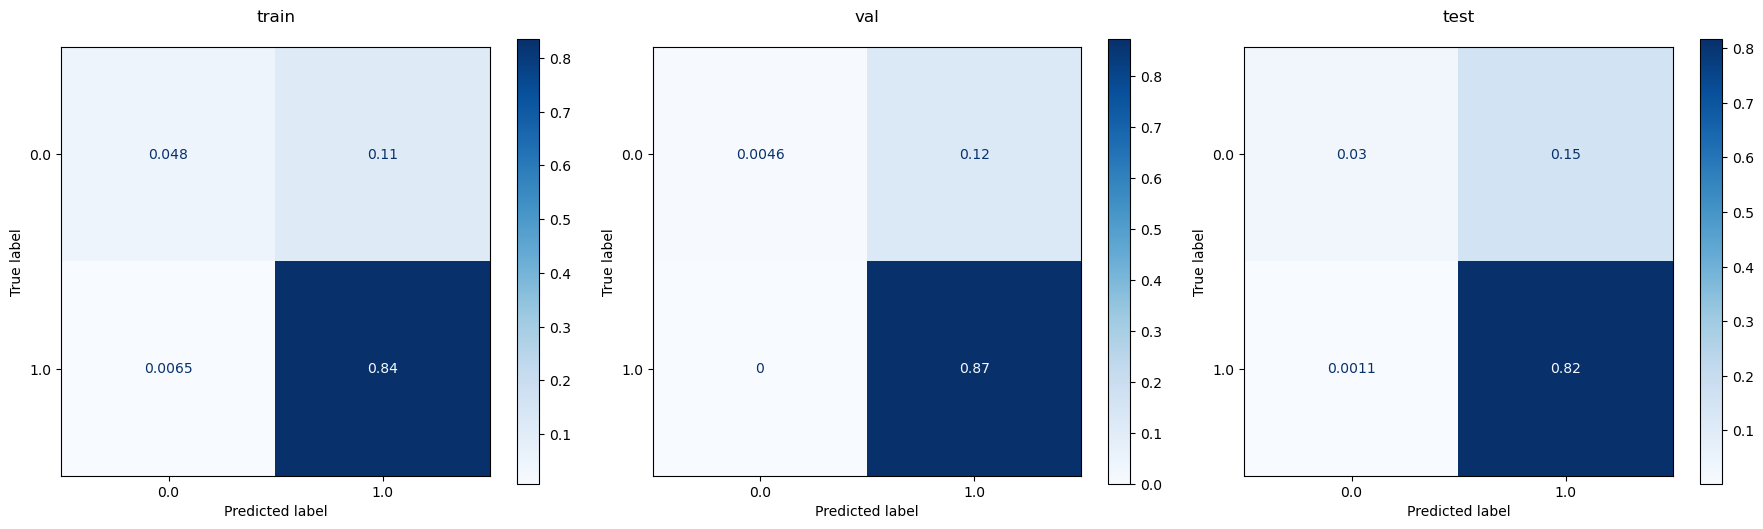

In [10]:
model_name = "LinearSvc"
model = models[model_name]["model"]

# Train
predictors_feature_engineering_transformer.fit(dataset.train_x)
model.fit(predictors_feature_engineering_transformer.transform(dataset.train_x), dataset.train_y)

# Evaluate and display metrics
print(score_evaluation(accuracy_score, predictors_feature_engineering_transformer, model, dataset))
print(score_evaluation(precision_score, predictors_feature_engineering_transformer, model, dataset))
print(score_evaluation(recall_score, predictors_feature_engineering_transformer, model, dataset))
print(score_evaluation(f1_score, predictors_feature_engineering_transformer, model, dataset))

# Evalutate and display CM
cm_results = confusion_matrix_evaluation(predictors_feature_engineering_transformer, model, dataset, normalize=normalize)
confusion_matrix_display(cm_results, model)

# Persist
model_subdir  = models_dir / camel_to_snake(model_name)
model_subdir.mkdir(exist_ok=True)
joblib.dump(dataset_transformer, model_subdir / "dataset_eng_pipeline.pkl")
joblib.dump(target_creation_transformer, model_subdir / "target_creation_eng_pipeline.pkl")
joblib.dump(remove_horizonless_rows_transformer, model_subdir / "remove_horizonless_rows_eng_pipeline.pkl")
joblib.dump(predictors_feature_engineering_transformer, model_subdir / "predictors_feature_eng_pipeline.pkl")
joblib.dump(model, model_subdir / "model.pkl");

### 3 - `SvcWithRbfKernel` 

In [ ]:
model_name = "SvcWithRbfKernel"
model = models[model_name]["model"]

# Train
predictors_feature_engineering_transformer.fit(dataset.train_x)
model.fit(predictors_feature_engineering_transformer.transform(dataset.train_x), dataset.train_y)

# Evaluate and display metrics
print(score_evaluation(accuracy_score, predictors_feature_engineering_transformer, model, dataset))
print(score_evaluation(precision_score, predictors_feature_engineering_transformer, model, dataset))
print(score_evaluation(recall_score, predictors_feature_engineering_transformer, model, dataset))
print(score_evaluation(f1_score, predictors_feature_engineering_transformer, model, dataset))

# Evalutate and display CM
cm_results = confusion_matrix_evaluation(predictors_feature_engineering_transformer, model, dataset, normalize=normalize)
confusion_matrix_display(cm_results, model)

# Persist
model_subdir  = models_dir / camel_to_snake(model_name)
model_subdir.mkdir(exist_ok=True)
joblib.dump(dataset_transformer, model_subdir / "dataset_eng_pipeline.pkl")
joblib.dump(target_creation_transformer, model_subdir / "target_creation_eng_pipeline.pkl")
joblib.dump(remove_horizonless_rows_transformer, model_subdir / "remove_horizonless_rows_eng_pipeline.pkl")
joblib.dump(predictors_feature_engineering_transformer, model_subdir / "predictors_feature_eng_pipeline.pkl")
joblib.dump(model, model_subdir / "model.pkl");

Score(score_name='accuracy_score', train=0.925, valid=0.904, test=0.91)
Score(score_name='precision_score', train=0.932, valid=0.905, test=0.912)
Score(score_name='recall_score', train=0.982, valid=0.995, test=0.985)


### 4 - `DecisionTree`

In [ ]:
model_name = "DecisionTree"
model = models[model_name]["model"]

# Train
predictors_feature_engineering_transformer.fit(dataset.train_x)
model.fit(predictors_feature_engineering_transformer.transform(dataset.train_x), dataset.train_y)

# Evaluate and display metrics
print(score_evaluation(accuracy_score, predictors_feature_engineering_transformer, model, dataset))
print(score_evaluation(precision_score, predictors_feature_engineering_transformer, model, dataset))
print(score_evaluation(recall_score, predictors_feature_engineering_transformer, model, dataset))
print(score_evaluation(f1_score, predictors_feature_engineering_transformer, model, dataset))

# Evalutate and display CM
cm_results = confusion_matrix_evaluation(predictors_feature_engineering_transformer, model, dataset, normalize=normalize)
confusion_matrix_display(cm_results, model)

# Persist
model_subdir  = models_dir / camel_to_snake(model_name)
model_subdir.mkdir(exist_ok=True)
joblib.dump(dataset_transformer, model_subdir / "dataset_eng_pipeline.pkl")
joblib.dump(target_creation_transformer, model_subdir / "target_creation_eng_pipeline.pkl")
joblib.dump(remove_horizonless_rows_transformer, model_subdir / "remove_horizonless_rows_eng_pipeline.pkl")
joblib.dump(predictors_feature_engineering_transformer, model_subdir / "predictors_feature_eng_pipeline.pkl")
joblib.dump(model, model_subdir / "model.pkl");

### 5 - `RandomForest`

In [ ]:
model_name = "RandomForest"
model = models[model_name]["model"]

predictors_feature_engineering_transformer.fit(dataset.train_x)
model.fit(predictors_feature_engineering_transformer.transform(dataset.train_x), dataset.train_y)

# Evaluate and display metrics
print(score_evaluation(accuracy_score, predictors_feature_engineering_transformer, model, dataset))
print(score_evaluation(precision_score, predictors_feature_engineering_transformer, model, dataset))
print(score_evaluation(recall_score, predictors_feature_engineering_transformer, model, dataset))
print(score_evaluation(f1_score, predictors_feature_engineering_transformer, model, dataset))

# Evalutate and display CM
cm_results = confusion_matrix_evaluation(predictors_feature_engineering_transformer, model, dataset, normalize=normalize)
confusion_matrix_display(cm_results, model)

# Persist
model_subdir  = models_dir / camel_to_snake(model_name)
model_subdir.mkdir(exist_ok=True)
joblib.dump(dataset_transformer, model_subdir / "dataset_eng_pipeline.pkl")
joblib.dump(target_creation_transformer, model_subdir / "target_creation_eng_pipeline.pkl")
joblib.dump(remove_horizonless_rows_transformer, model_subdir / "remove_horizonless_rows_eng_pipeline.pkl")
joblib.dump(predictors_feature_engineering_transformer, model_subdir / "predictors_feature_eng_pipeline.pkl")
joblib.dump(model, model_subdir / "model.pkl");

### 6. Test metrics consistancy with pikled pipelines and  models

In [ ]:
dataset_transformer = joblib.load(model_subdir / "dataset_eng_pipeline.pkl")
target_creation_transformer = joblib.load(model_subdir / "target_creation_eng_pipeline.pkl")
remove_horizonless_rows_transformer = joblib.load(model_subdir / "remove_horizonless_rows_eng_pipeline.pkl")
predictors_feature_engineering_transformer =joblib.load(model_subdir / "predictors_feature_eng_pipeline.pkl")
model = joblib.load(model_subdir / "model.pkl")

### Transform the dataset

In [ ]:
transformed_data, created_target = transform_dataset_and_create_target(
    df,   
    dataset_transformer,
    target_creation_transformer,
)

dataset = prepare_binary_classification_tabular_data(
    transformed_data,
    created_target,
)

dataset = remove_horizonless_rows(
    dataset,
    remove_horizonless_rows_transformer,
)

### Display confusion matrix

In [ ]:
# Evalutate and display CM
cm_results = confusion_matrix_evaluation(predictors_feature_engineering_transformer, model, dataset, normalize=normalize)
confusion_matrix_display(cm_results, model)